# 2D ERT modeling and inversion (Complex)
### This one tries to copy the deposit shape and simulate the geothermal plume as a diffusive fluid

There are also some changes to optimize the geometry and the inversion

In [140]:
import matplotlib.pyplot as plt
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert


--------------------------------------------------------------------------------
  Date: Tue Aug 29 19:23:43 2023 -05

                OS : Linux
            CPU(s) : 8
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.6 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32)
  [GCC 12.3.0]

           pygimli : 1.4.3
            pgcore : 1.4.0
             numpy : 1.25.0
        matplotlib : 3.7.2
             scipy : 1.11.2
           IPython : 8.14.0
           pyvista : 0.41.1
--------------------------------------------------------------------------------


## Geometry definition

In [141]:
world = mt.createWorld(start=(-350, -250), end=(350, 0))

### Define geology below the deposit

Fault and inyection point definition

In [142]:
iPos = (-125, -200) #Inyection Point
fault = mt.createPolygon([iPos, (-150, -250)], isClosed= True)

Define Floresta and Cretacic

In [143]:
layer = mt.createPolygon([(-350, -150), iPos, (350, -150)], 
                         addNodes=100, interpolate='spline', isClosed=False)

Define Geometry

(<Axes: >, None)

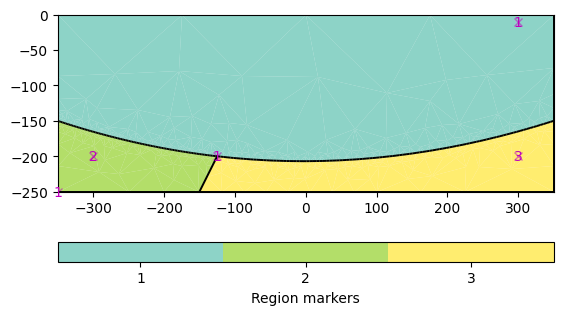

In [144]:
world += layer
world += fault

world.addRegionMarker((300, -10), marker=1)
world.addRegionMarker((-300, -200), marker=2)
world.addRegionMarker((300, -200), marker=3)

pg.show(world)

## Synthetic data generation
Create a Schlumberger ('slm') measuring scheme with 96 electrodes along a 700m line (-350 to 350)


(<Axes: >, None)

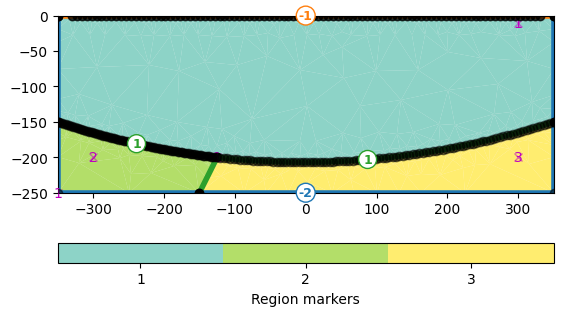

In [145]:
# Sensors should no be on the corner so we put them a little inside
scheme = ert.createData(elecs=np.linspace(start=-330, stop=330, num=96),
                           schemeName='slm')

# we need local refinement at the electrodes to achieve sufficient accuracy
for p in scheme.sensors():
    world.createNode(p)
    world.createNode(p - [0, 0.1])

pg.show(world, markers=True, showNodes=True)

**IMPORTANT:** Mesh needs to be created after adding electrodes to world geometry

In [146]:
mesh = mt.createMesh(world, quality=33, area=100)

We need larger boundary to avoid numerical issues.
Note: appendTriangleBoundary is just an easier approach, but we can get better results if we create the boundary manually on geometry level.

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7f056b5113f0>)

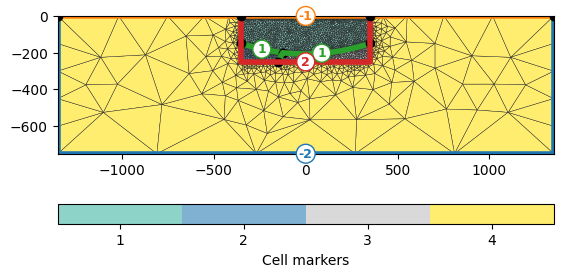

In [147]:
mesh = mt.appendTriangleBoundary(mesh, xbound=1000, ybound=500, marker=4)

pg.show(mesh, markers=True, showMesh=True)

Add rho values to our mesh

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7f0596014df0>)

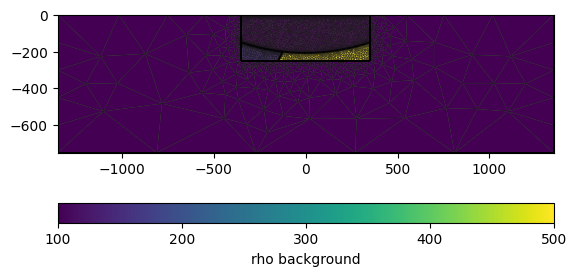

In [148]:
rhoMin = 1
rhoMax = 100
rho0 = pg.solver.cellValues(mesh, {1: 100,
                                   2: 150,
                                   3: 500,
                                   4: 100,}
                                   )

pg.show(mesh, rho0, label='rho background', showMesh=True)

Simulate the ert with our forward mesh

ModellingBase::setMesh() copying new mesh ... relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.03000043647093865 : 0.030447015828132647
Found datafile: 96 electrodes
Found: 96 free-electrodes
rMin = 3.47368, rMax = 1320
NGauLeg + NGauLag for inverse Fouriertransformation: 15 + 4
Found non-Neumann domain
0.124418 s
FOP updating mesh dependencies ... 2.9e-06 s
Calculating response for model: min = 100 max = 500
Allocating memory for primary potential...... 0.0118085

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 2.66903s
Response: min = 99.8382 max = 110.197 mean = 102.142
Reciprocity rms(modelReciprocity) 0.011245%, max: 0.0841865%


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7f05974007c0>)

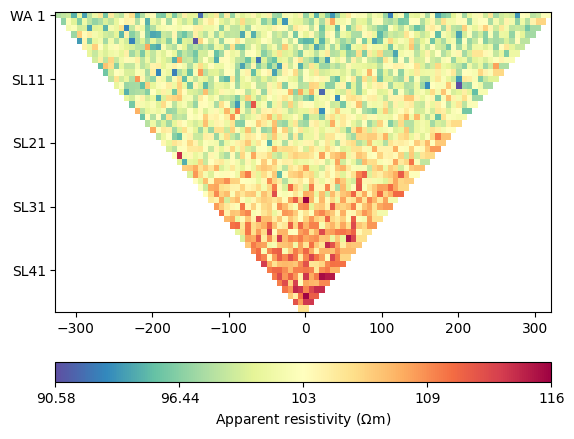

In [149]:
data = ert.simulate(mesh, scheme=scheme, res=rho0, 
                    noiseLevel=3, noiseAbs=1e-6, seed=1337)

pg.show(data)

### Define diffusive fluid

The flow can be either anisotropic or isotropic

Mesh:  Mesh: Nodes: 9884 Cells: 18189 Boundaries: 28072
Assembling time:  0.319790605
Solving time:  0.208940903


/home/ubuntu_jc/anaconda3/envs/pg/lib/python3.10/site-packages/pygimli/viewer/mpl/meshview.py:1001: UserWarning: linewidths is ignored by contourf
  gci = ax.tricontourf(x, y, triangles, z,


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7f05714a0700>)

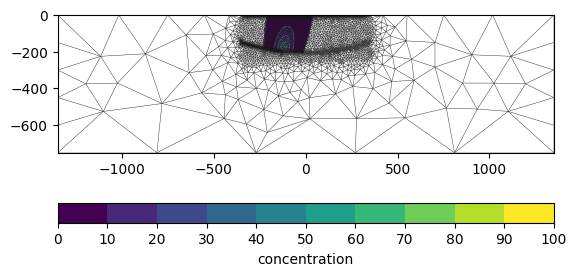

In [150]:
#Anisotropic flow
diff = pg.solver.cellValues(mesh, {'3,2,4': pg.solver.createAnisotropyMatrix(0.1, 0.1, 0.0), 1: pg.solver.createAnisotropyMatrix(1, 100, 20.0*np.pi/180)}) 

#Isotropic and homogeneous flow
#diff = pg.solver.cellValues(mesh, {4: 1e-2, 3: 1e-2, 2: 1e-2, 1: 100}) 

iPosID = mesh.findNearestNode(iPos)

# stationary solution 
Conc = pg.solver.solve(mesh, a=diff,
                    bc={'Dirichlet': {'-1': 0.0}, 'Neumann': {'-2': -1},
                        'Node':[iPosID, 100]}, verbose=True)

pg.show(mesh, Conc, label='concentration', showMesh=True, 
        cMin=0, cMax=100, nCols=10, nLevs=11, linewidths=0.5)

### Simulate resistivity of the diffusive fluid according to the concentration

In [151]:
Conc = pg.interpolate(mesh, Conc, mesh.cellCenters())
Conc[Conc < 0] = 0

# add anomal resistivity as linear function from rhoMin to rhoMax depending on concentration
rho = 1/(1/np.array(rho0) + 1/(rhoMin)*(Conc/100))

In [152]:
data = ert.simulate(mesh, scheme=scheme, res=rho, noiseLevel=3,
                    noiseAbs=1e-6, seed=1337)

pg.info(np.linalg.norm(data['err']), np.linalg.norm(data['rhoa']))
pg.info('Simulated data', data)
pg.info('The data contains:', data.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

29/08/23 - 19:23:58 - pyGIMLi - INFO - 1.4181644677212828 3482.127891710182
29/08/23 - 19:23:58 - pyGIMLi - INFO - Simulated data Data: Sensors: 96 data: 2209, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
29/08/23 - 19:23:58 - pyGIMLi - INFO - The data contains: ['a', 'b', 'err', 'i', 'ip', 'iperr', 'k', 'm', 'n', 'r', 'rhoa', 'u', 'valid']
29/08/23 - 19:23:58 - pyGIMLi - INFO - Simulated rhoa (min/max) 19.900736999948492 108.11331101656442
29/08/23 - 19:23:58 - pyGIMLi - INFO - Selected data noise %(min/max) 3.000043647344381 3.1264799581283254


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.03000043647344381 : 0.031264799581283254
ModellingBase::setMesh() copying new mesh ... Found datafile: 96 electrodes
Found: 96 free-electrodes
rMin = 3.47368, rMax = 1320
NGauLeg + NGauLag for inverse Fouriertransformation: 15 + 4
Found non-Neumann domain
0.114385 s
FOP updating mesh dependencies ... 1.9e-06 s
Calculating response for model: min = 1.16383 max = 500
Allocating memory for primary potential...... 0.0075136

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 2.60262s
Response: min = 20.7063 max = 100.954 mean = 69.2321
Reciprocity rms(modelReciprocity) 0.501038%, max: 1.90806%


Filter all values and tokens in the data container.
Its possible that there are some negative data values due to noise and
huge geometric factors. So we need to remove them.



29/08/23 - 19:23:58 - pyGIMLi - INFO - Filtered rhoa (min/max) 19.900736999948492 108.11331101656442


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7f0567d0f7f0>)

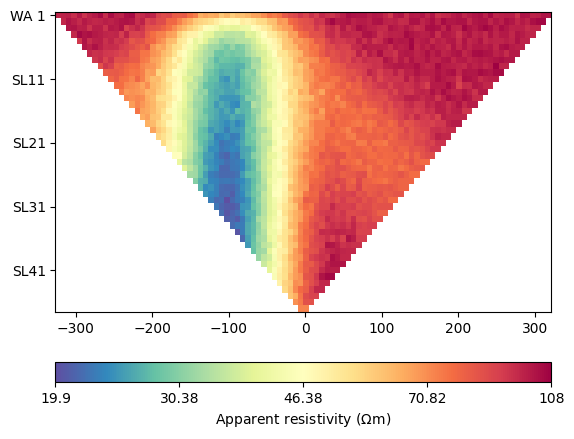

In [153]:
data.remove(data['rhoa'] < 0)
pg.info('Filtered rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))

# You can save the data for further use
data.save('Forward_mod.dat')

# You can take a look at the data
ert.show(data)

## Inversion with the ERTManager
Initialize the ERTManager, e.g. with a data container or a filename.



In [154]:
mgr = ert.ERTManager('Forward_mod.dat')

Run the inversion with the preset data. 
Since I set noise level to 3%, chi^2 target should be close to 0.9 or sighly above, also the regularization parameter should be in the range of 10 to 50 (I chose 30).



In [155]:
inv = mgr.invert(lam=30, verbose=True)
np.testing.assert_approx_equal(mgr.inv.chi2(), 0.9, significant=1)

29/08/23 - 19:23:58 - pyGIMLi - INFO - Found 2 regions.
29/08/23 - 19:23:58 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
29/08/23 - 19:23:59 - pyGIMLi - INFO - Found 2 regions.
29/08/23 - 19:23:59 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
29/08/23 - 19:23:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
29/08/23 - 19:23:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
29/08/23 - 19:23:59 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 3623 Cells: 6784 Boundaries: 5318


Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  0
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
Quality milliseconds:  1

Writing vertices.
Writing triangles.
Writing segments.
Writing edges.

Output milliseconds:  0
Total running milliseconds:  1

Statistics:

  Input vertices: 199
  Input segments: 200
  Input holes: 0

  Mesh vertices: 964
  Mesh triangles: 1696
  Mesh edges: 2659
  Mesh exterior boundary edges: 230
  Mesh interior boundary edges: 27
  Mesh subsegments (constrained edges): 257

min/max(dweight) = 32.5747/33.3327


29/08/23 - 19:23:59 - pyGIMLi - INFO - Use median(data values)=76.7804435609063
29/08/23 - 19:23:59 - pyGIMLi - INFO - Created startmodel from forward operator: 1415 [76.7804435609063,...,76.7804435609063]
29/08/23 - 19:23:59 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 31.9849/33.3328
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x7f0567f41fd0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x7f0596103830>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x7f0567f41a80>
min/max (data): 19.9/108
min/max (error): 3%/3.13%
min/max (start model): 76.78/76.78
--------------------------------------------------------------------------------
Calculating response for model: min = 76.7804 max = 76.7804
Allocating memory for primary potential...... 0.0047552

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 1.04939s
Response: min = 76.6434 max = 76.7928 mean = 76.7622
Reciprocity rms(modelReciprocity) 0%, max: 0%
min/max(dweight) = 31.9849/33.3328
Building constraints matrix
constraint matrix of size(nBounds x nModel) 2011 x 1415
check Jacobian: wrong dimensions: (0x0) should be (2209x1415)  force: 1
jacobian size invalid, forced recalc: 1
calculating ja

Let the ERTManger show you the model of the last successful run and how it
fits the data. 
## Show data, model response, and model.



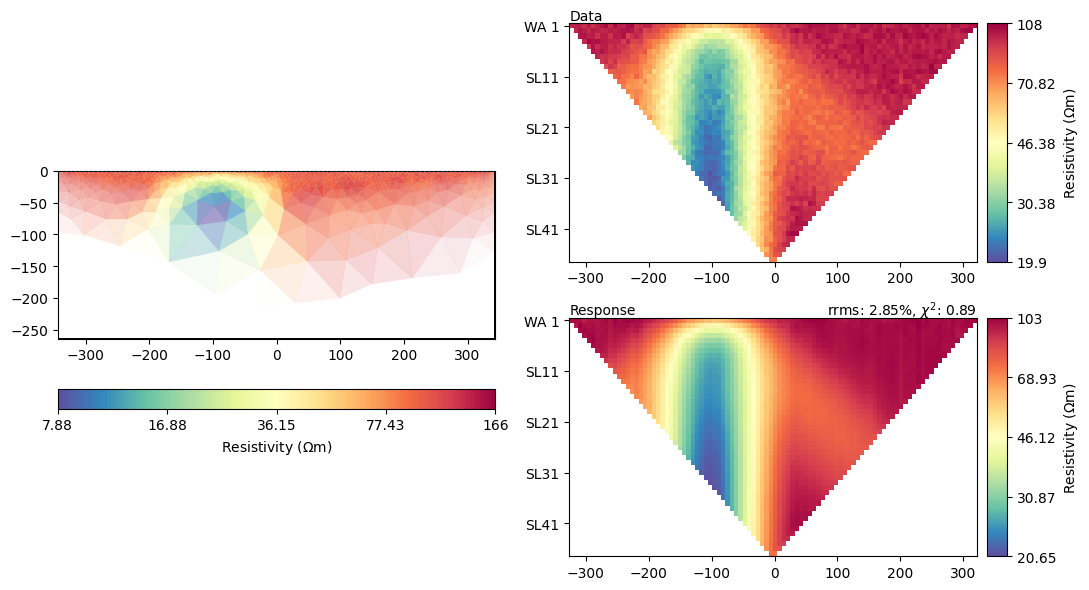

In [156]:
mgr.showResultAndFit()
meshPD = pg.Mesh(mgr.paraDomain) # Save copy of para mesh for plotting later